In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from itertools import product
from ipywidgets import IntProgress
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

In [106]:
# download data
train = pd.read_csv('train_kaggle.csv')
test = pd.read_csv('test_kaggle.csv')
train['Date'] = pd.to_datetime(train['Date'], dayfirst = True)
test['Date'] = pd.to_datetime(test['Date'], dayfirst = True)
train.set_index(['Date'], inplace=True)
test.set_index(['Date'], inplace=True)

In [107]:
train['Promo'] = train['Promo'].fillna(0)
train.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
train['Regular_Price'] = train['Regular_Price'].ffill().bfill()
train.reset_index().set_index(['Date'], inplace=True)

# add actual price (promo price when promo occurred or regular price otherwise)

train['Actual_Price'] = train.Promo_Price.combine_first(train.Regular_Price) 
train.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price
Date,,,,,,,
2015-01-01,1,1,0.0,22,163.78,NaN,163.78
2015-01-02,1,1,0.0,41,163.78,NaN,163.78
2015-01-03,1,1,0.0,35,163.78,NaN,163.78
2015-01-04,1,1,0.0,72,163.78,NaN,163.78
2015-01-05,1,1,0.0,25,163.78,NaN,163.78


In [108]:
test['Promo'] = test['Promo'].fillna(0)
test.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
test['Regular_Price'] = test['Regular_Price'].ffill().bfill()
test.reset_index().set_index(['Date'], inplace=True)

# add actual price (promo price when promo occurred or regular price otherwise)

test['Actual_Price'] = test.Promo_Price.combine_first(test.Regular_Price) 
test.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price
Date,,,,,,,
2016-05-23,1,1,1.0,NaN,128.98,119.6,119.60
2016-05-24,1,1,0.0,NaN,128.98,NaN,128.98
2016-05-25,1,1,0.0,NaN,131.70,NaN,131.70
2016-05-26,1,1,0.0,NaN,131.70,NaN,131.70
2016-05-27,1,1,0.0,NaN,131.70,NaN,131.70


In [109]:
train.reset_index(inplace=True)
train["weekday"] = train.Date.dt.weekday
train["monthday"] = train.Date.dt.day
train['is_weekend'] = train.weekday.isin([5, 6]) * 1

test.reset_index(inplace=True)
test["weekday"] = test.Date.dt.weekday
test["monthday"] = test.Date.dt.day
test['is_weekend'] = test.weekday.isin([5, 6]) * 1

In [110]:
data = pd.concat([train, test]).set_index('Date').reset_index()
data.head()

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price,weekday,monthday,is_weekend
0,2015-01-01,1,1,0.0,22.0,163.78,NaN,163.78,3,1,0
1,2015-01-02,1,1,0.0,41.0,163.78,NaN,163.78,4,2,0
2,2015-01-03,1,1,0.0,35.0,163.78,NaN,163.78,5,3,1
3,2015-01-04,1,1,0.0,72.0,163.78,NaN,163.78,6,4,1
4,2015-01-05,1,1,0.0,25.0,163.78,NaN,163.78,0,5,0


# STATIC

In [9]:
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_


def lagged_features(data
                    , target_var = 'demand'
                    , id_columns = ['Store_id']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , preaggreagation_methods = ['mean'] # ['mean', 'count']
                    , aggregation_methods = ['mean', 'median', percentile(10),  percentile(90)]
                    , filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        by_store - whether calculate stats by stores or not
        id_columns - columns to groups
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        preaggreagation_methods - applied methods before rolling
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    out_df = deepcopy(data)
    df = deepcopy(data)
    true_demand = df['Demand']

    if filters is None:
        filters = {'':{''}}
    
    ## total number of filters
    total = 0
    for x in flts:
        total += len(flts[x].items())
    
    progress = IntProgress(min=0, max=total)
    display(progress)
    
    for col_name in flts:
        for name, f in flts[col_name].items():
            condition = col_name + f
            
            if len(condition) > 0:
                idx = df.eval(condition)
            else:
                idx = df.index >= 0
        
            if len(df[idx].index) > 0:

                df.loc[~idx, 'Demand'] = np.nan
                for w in windows:
                    for preaggr in preaggreagation_methods:
                        for method in aggregation_methods:

                            lf_df = df.set_index('Date').sort_index().groupby(id_columns + ['Date']).\
                            agg(preaggr).rolling(window=w, min_periods=1).agg(method)

                            for l in lags:
                                method_name = method.__name__ if type(method) != str else method
                                new_names = {x: "lag{0}_wdw{1}_key{2}_preag{3}_ag{4}_{5}_{6}".
                                             format(l, w, '_'.join(id_columns), preaggr, method_name, x, name) for x in lf_df.columns}

                                out_df = pd.merge(out_df, lf_df['Demand'].shift(l).reset_index().rename(columns = new_names),
                                                  how='left', on=id_columns + ['Date'])
            df['Demand'] = true_demand
            progress.value += 1
    return out_df


# DYNAMIC COMBINE

In [68]:
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_


def lagged_features(data
                    , target_vars = ['Demand']
                    , id_columns = ['Store_id']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , preaggreagation_methods = ['mean'] # ['mean', 'count']
                    , aggregation_methods = ['mean', 'median', percentile(10),  percentile(90)]
                    , filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        by_store - whether calculate stats by stores or not
        id_columns - columns to groups
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        preaggreagation_methods - applied methods before rolling
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    out_df = deepcopy(data).set_index(id_columns + ['Date'])
    df = deepcopy(data)

    if filters is None:
        filters = {'':{''}}
    
    ## total number of filters
    total = 0
    for x in flts:
        total += len(flts[x].items())
    
    progress = IntProgress(min=0, max=total)
    display(progress)
    
    for col_name in flts:
        
        for name, cond in flts[col_name].items():
            condition = col_name + cond
            
            if len(condition) > 0:
                idx = df.eval(condition)
            else:
                idx = df.index >= 0
        
            if len(df[idx].index) > 0:

                for w in windows:
                    for preaggr in preaggreagation_methods:
                        for method in aggregation_methods:

                            lf_df = df[idx].set_index('Date').sort_index().groupby(id_columns + ['Date']).\
                            agg(preaggr).rolling(window=w, min_periods=1).agg(method)

                            for l in lags:
                            
                                method_name = method.__name__ if type(method) != str else method
                                new_names = {x: "lag{0}_wdw{1}_key{2}_preag{3}_ag{4}_{5}_dynamic".
                                             format(l, w, '_'.join(id_columns), preaggr, method_name, x) for x in target_vars}
                                for _, new_name in new_names.items():
                                    if new_name not in out_df.columns:
                                        out_df[new_name] = np.nan
#                                 print(out_df.columns)
#                                 print(lf_df['Demand'])
                                
                                out_df.update(lf_df['Demand'].shift(l).reset_index().rename(columns=new_names).set_index(id_columns + ['Date']))
#                                 out_df = pd.merge(out_df, lf_df['Demand'].shift(l).reset_index().rename(columns = new_names),
#                                                   how='left', on=id_columns + ['Date'])
            progress.value += 1
    
    return out_df.reset_index()



# DYNAMIC GROUPBY

In [153]:
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_


def lagged_features(data
                    , target_vars = ['Demand']
                    , id_columns = ['SKU_id']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , preaggreagation_methods = ['mean'] # ['mean', 'count']
                    , aggregation_methods = ['mean', 'median', percentile(10),  percentile(90)]
                    , dynamic_filters = ['weekday']
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_vars - column names which are used to calculate lagged features
        by_store - whether calculate stats by stores or not
        id_columns - columns to groups
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        preaggreagation_methods - applied methods before rolling
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    
    out_df = deepcopy(data).set_index(id_columns + ['Date'])
    df = deepcopy(data)
    
    total = len(target_vars) * len(lags) * len(windows) * len(preaggreagation_methods) * len(aggregation_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)
    for f in dynamic_filters:
        for w in windows:
            for preaggr in preaggreagation_methods:
                for method in aggregation_methods:
                    lf_df = df.set_index('Date').sort_index().groupby([f] + id_columns + ['Date']).\
                    agg(preaggr)[target_vars].rolling(window=w, min_periods=1).agg(method)
                    
                    for l in lags:

                        method_name = method.__name__ if type(method) != str else method
                        new_names = {x: "lag{0}_wdw{1}_key{2}_preag{3}_ag{4}_{5}_dynamic".
                                     format(l, w, '_'.join(id_columns), preaggr, method_name, x) for x in target_vars}
                        out_df = pd.merge(out_df, lf_df[target_vars].shift(l).rename(columns=new_names),
                                          how='left', on=id_columns + ['Date'])
                        progress.value += 1
    
    return out_df



In [172]:
# flts = {
#         'weekday' : {'md':'==0', 'tue':'==1', 'wd':'==2', 'th':'==3', 'fr':'==4', 'sa':'==5', 'su':'==6'}
#        }

data_lagged_features = lagged_features(data, target_vars = ['Demand']
                    , id_columns = ['SKU_id']
                    , lags = [1, 2, 4, 6]
                    , windows = [1, 2, 4, 8, 12]
                    , preaggreagation_methods = ['mean'] # ['mean', 'count']
                    , aggregation_methods = ['mean', 'median', percentile(10)]
                    , dynamic_filters = ['weekday']
                    )

data_lagged_features = data_lagged_features.reset_index()

IntProgress(value=0, max=60)

In [327]:
data_lagged_features[data_lagged_features['Demand'].isna()].isna().sum().sort_values().tail(15)

lag4_wdw2_keySKU_id_preagmean_agmean_Demand_dynamic         0
lag2_wdw2_keySKU_id_preagmean_agpctl10_Demand_dynamic    1532
lag2_wdw2_keySKU_id_preagmean_agmean_Demand_dynamic      1532
lag2_wdw2_keySKU_id_preagmean_agmedian_Demand_dynamic    1532
lag1_wdw2_keySKU_id_preagmean_agpctl10_Demand_dynamic    3034
lag2_wdw1_keySKU_id_preagmean_agpctl10_Demand_dynamic    3034
lag2_wdw1_keySKU_id_preagmean_agmean_Demand_dynamic      3034
lag1_wdw2_keySKU_id_preagmean_agmean_Demand_dynamic      3034
lag1_wdw2_keySKU_id_preagmean_agmedian_Demand_dynamic    3034
lag2_wdw1_keySKU_id_preagmean_agmedian_Demand_dynamic    3034
Promo_Price                                              4456
lag1_wdw1_keySKU_id_preagmean_agpctl10_Demand_dynamic    4516
lag1_wdw1_keySKU_id_preagmean_agmean_Demand_dynamic      4516
lag1_wdw1_keySKU_id_preagmean_agmedian_Demand_dynamic    4516
Demand                                                   5970
dtype: int64

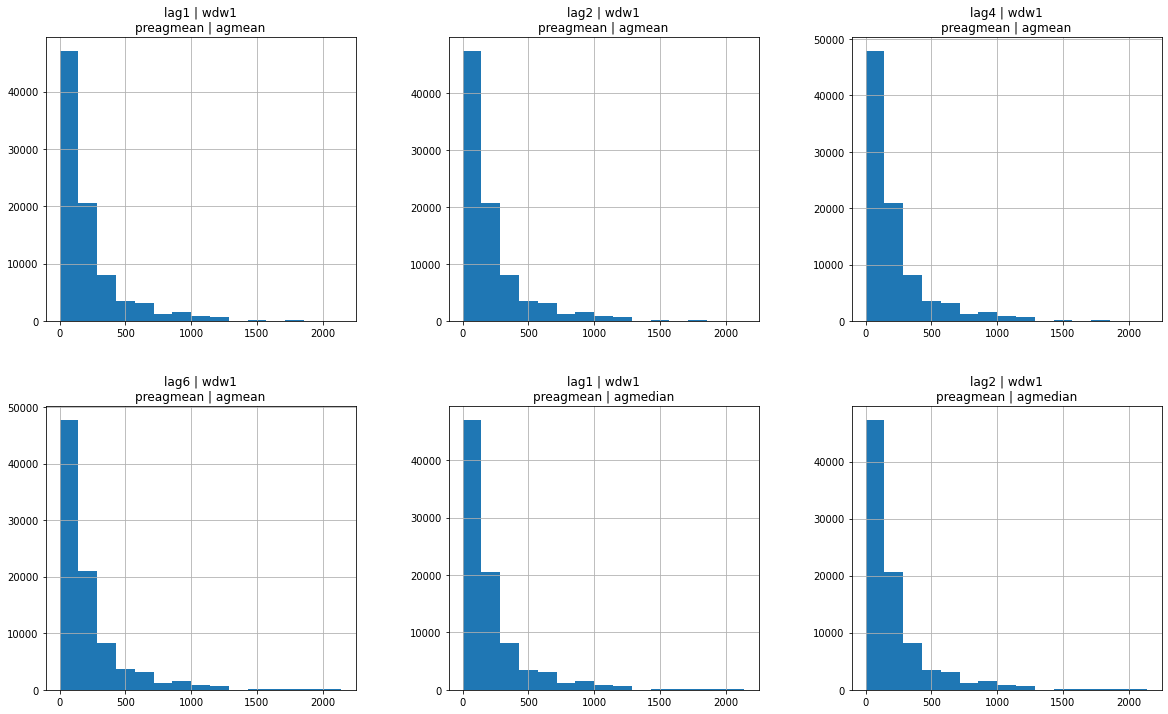

In [317]:
new_names = {}
for x in data_lagged_features.columns[11:17]:
    name = x.split('_')
    lag, w = name[0], name[1]
    preagr, agr = name[4], name[5]
    new_name = lag + ' | '+ w + '\n' +  preagr + ' | ' + agr
    new_names[x] = new_name


fig, ax = plt.subplots(2, 3, figsize = (20,12))
data_lagged_features[data_lagged_features.columns[11:17]].rename(columns=new_names).hist(ax=ax, bins=15)
plt.show()

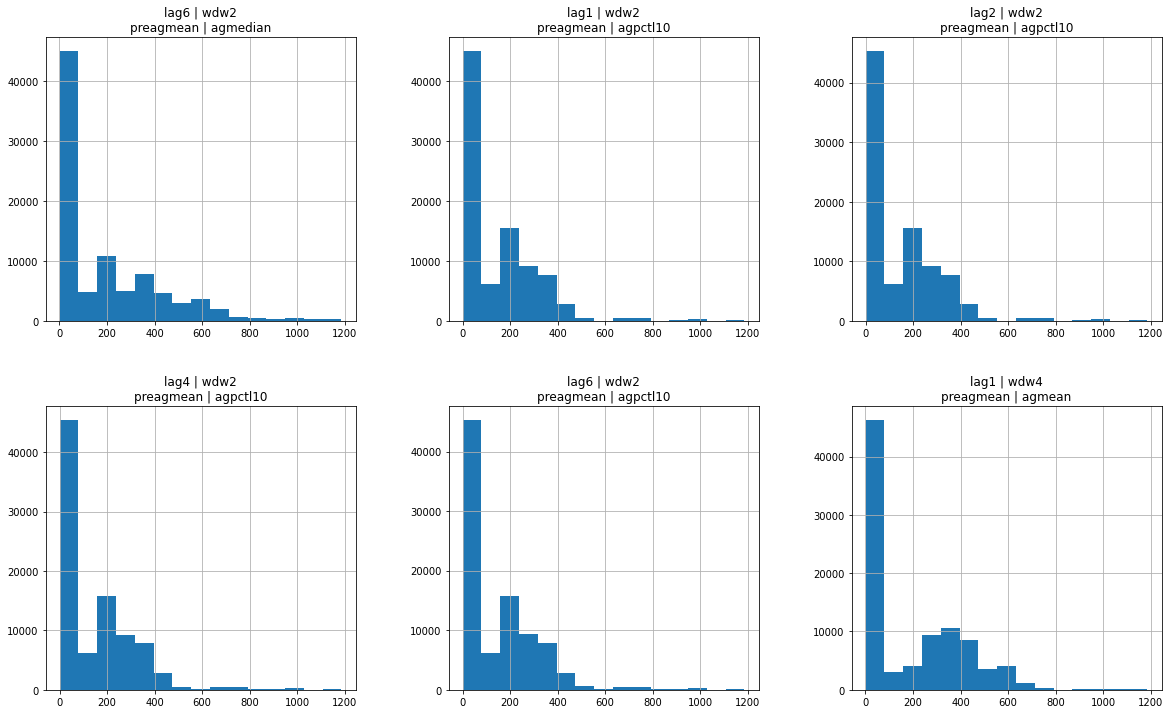

In [318]:
new_names = {}
for x in data_lagged_features.columns[30:36]:
    name = x.split('_')
    lag, w = name[0], name[1]
    preagr, agr = name[4], name[5]
    new_name = lag + ' | '+ w + '\n' +  preagr + ' | ' + agr
    new_names[x] = new_name


fig, ax = plt.subplots(2, 3, figsize = (20,12))
data_lagged_features[data_lagged_features.columns[30:36]].rename(columns=new_names).hist(ax=ax, bins=15)

plt.show()


<AxesSubplot:title={'center':'Lag2Window2Mean'}, xlabel='Date'>

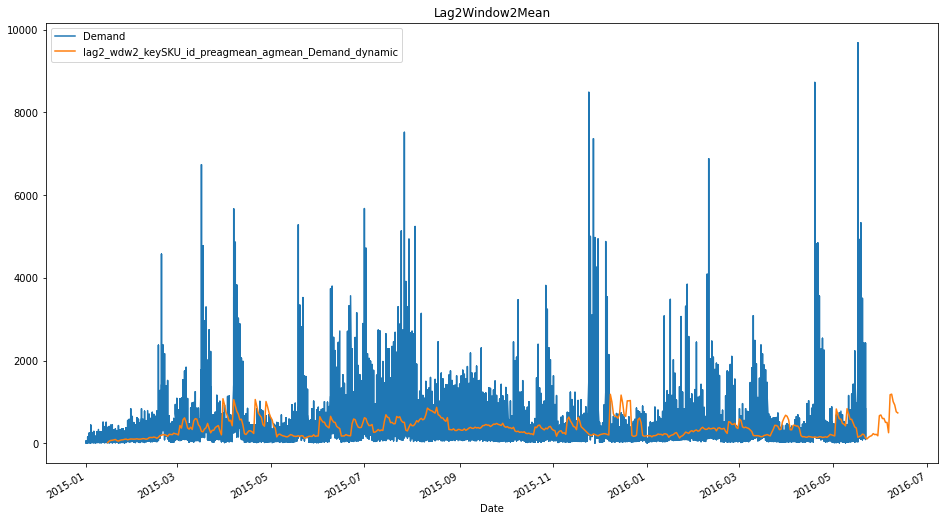

In [330]:
data_lagged_features[data_lagged_features['SKU_id'] == 1].set_index('Date')[['Demand', 'lag2_wdw2_keySKU_id_preagmean_agmean_Demand_dynamic']].plot(figsize=(16,9), title='Lag2Window2Mean')



<AxesSubplot:title={'center':'Lag2Window2Mean'}, xlabel='Date'>

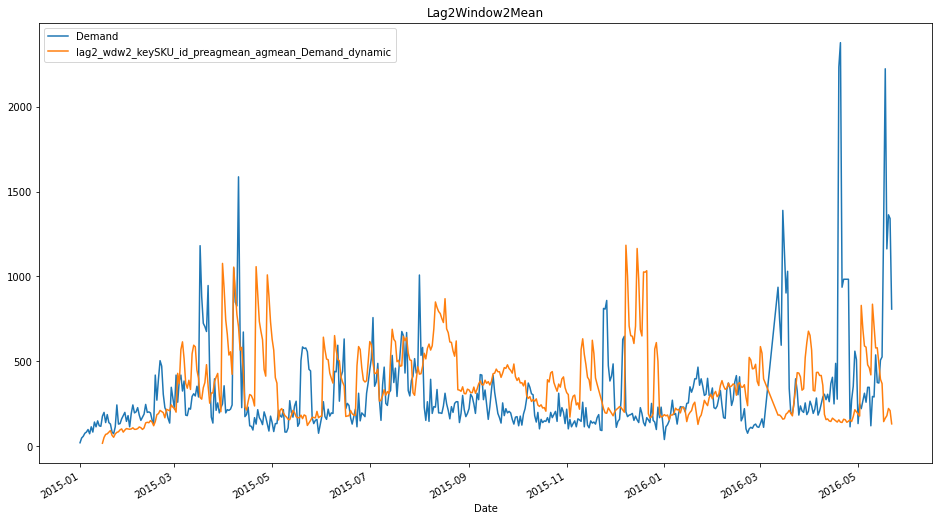

In [322]:
data_lagged_features[data_lagged_features['SKU_id'] == 1].set_index('Date')[['Demand', 'lag2_wdw2_keySKU_id_preagmean_agmean_Demand_dynamic']].head(5000).tail(500).plot(figsize=(16,9), title='Lag2Window2Mean')



<AxesSubplot:title={'center':'Lag2Window2Median'}, xlabel='Date'>

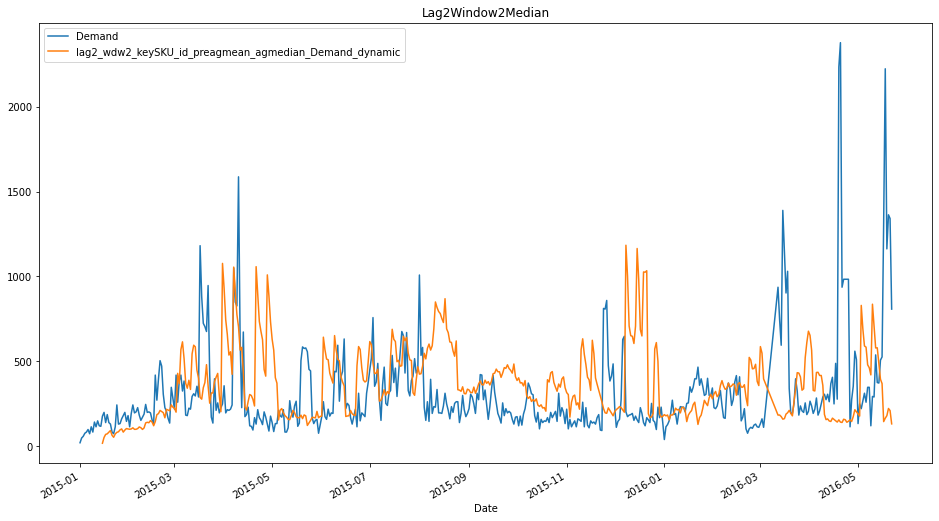

In [324]:
data_lagged_features[data_lagged_features['SKU_id'] == 1].set_index('Date')[['Demand', 'lag2_wdw2_keySKU_id_preagmean_agmedian_Demand_dynamic']].head(5000).tail(500).plot(figsize=(16,9), title='Lag2Window2Median')



<AxesSubplot:title={'center':'Lag1Window1Mean'}, xlabel='Date'>

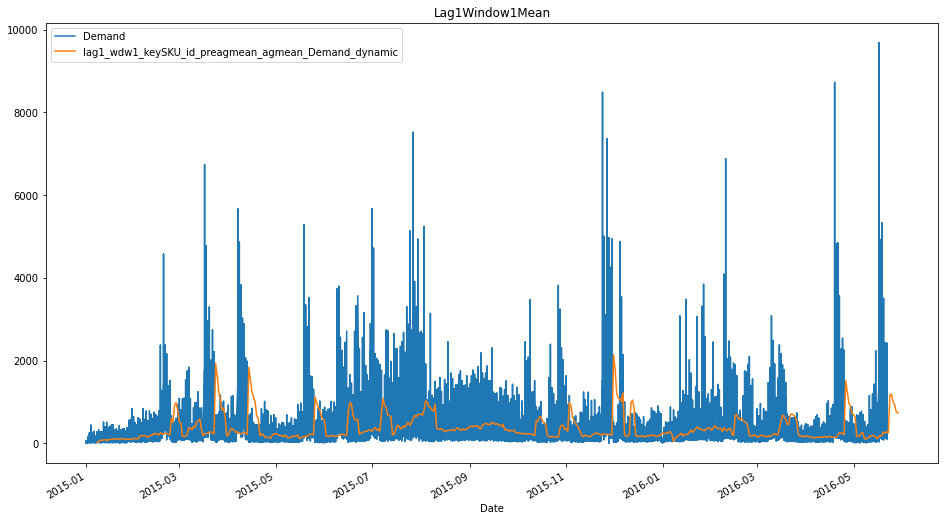

In [334]:
data_lagged_features[data_lagged_features['SKU_id'] == 1].set_index('Date')[['Demand', 'lag1_wdw1_keySKU_id_preagmean_agmean_Demand_dynamic']].plot(figsize=(16,9), title='Lag1Window1Mean')



<AxesSubplot:title={'center':'Lag1Window1Mean'}, xlabel='Date'>

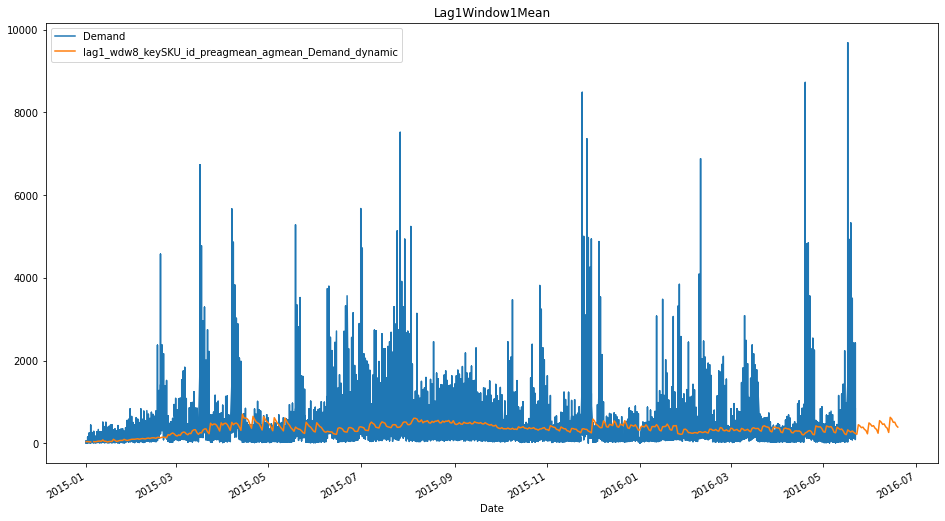

In [335]:
data_lagged_features[data_lagged_features['SKU_id'] == 1].set_index('Date')[['Demand', 'lag1_wdw8_keySKU_id_preagmean_agmean_Demand_dynamic']].plot(figsize=(16,9), title='Lag1Window1Mean')


# TO ANALYSE

In [59]:


df = deepcopy(data)
lf_df = df.set_index('Date').sort_index().groupby(['weekday', 'SKU_id'] + ['Date']).\
                            agg('mean').rolling(window=14, min_periods=1).agg('mean')


out_df = pd.merge(df, lf_df['Demand'].shift(2).reset_index().rename(columns = {'Demand': 'Rolled'}),
                                                  how='left', on=['SKU_id'] + ['Date'])


In [325]:
# df.set_index('Date').sort_index().groupby(['SKU_id'] + ['Date']).head(1)

In [72]:
lf_df = df.set_index(['weekday', 'SKU_id', 'Date']).sort_index().groupby(level=['weekday', 'SKU_id', 'Date']).agg('mean').rolling(14, min_periods=1).mean()
out_df = pd.merge(df, lf_df['Demand'].shift(2).reset_index().rename(columns = {'Demand': 'Rolled'}),
                                                  how='left', on=['SKU_id'] + ['Date'])

# lf_df['Demand'].shift(2).reset_index()

In [326]:
# data[(data['weekday'] == 0)].groupby(['SKU_id', 'Date']).mean().rolling(2, min_periods=1).mean()['Demand']



In [96]:
## count - useless
## при использовании shift с фильтрами, lag и window должны указываться в неделях если говорим про фильтр weekday

## posssible structures: {'dynamic': {'filter_name': 'col_name'},
##                        'static': {'col_name': {'filter_name' :'condition'}}
##                       }
